<a href="https://www.kaggle.com/code/charunumesh/ps-s3-e16?scriptVersionId=132138383" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,  StratifiedKFold, KFold,GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import  PolynomialFeatures, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets, ensemble
from catboost import CatBoostRegressor
import xgboost as xgb
# from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv


## Import the data

In [2]:
## import the train dataset
df_train = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
df_train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [3]:
### load the test data
df_test = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')
df_test.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


## basic data information

In [4]:
def check_data(data, data_type):
    data = data.drop('id', axis=1)
    print(f"basic informataion on {data_type} \n")

    basics = {"data info": data.info(),"data types are":data.dtypes, 'length of the dataset':len(data), 
              'null values are':data.isnull().sum(), 'distribution of the dataset':data.describe()}

    [print('*'*50, '\n', i, '\n',j) for i,j in basics.items()]

In [5]:
check_data(df_train, 'TRAIN DATA')

basic informataion on TRAIN DATA 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             74051 non-null  object 
 1   Length          74051 non-null  float64
 2   Diameter        74051 non-null  float64
 3   Height          74051 non-null  float64
 4   Weight          74051 non-null  float64
 5   Shucked Weight  74051 non-null  float64
 6   Viscera Weight  74051 non-null  float64
 7   Shell Weight    74051 non-null  float64
 8   Age             74051 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 5.1+ MB
************************************************** 
 data info 
 None
************************************************** 
 data types are 
 Sex                object
Length            float64
Diameter          float64
Height            float64
Weight            float64
Shucked Weight    float64
Visc

In [6]:
check_data(df_test, 'TEST DATA')

basic informataion on TEST DATA 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49368 entries, 0 to 49367
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             49368 non-null  object 
 1   Length          49368 non-null  float64
 2   Diameter        49368 non-null  float64
 3   Height          49368 non-null  float64
 4   Weight          49368 non-null  float64
 5   Shucked Weight  49368 non-null  float64
 6   Viscera Weight  49368 non-null  float64
 7   Shell Weight    49368 non-null  float64
dtypes: float64(7), object(1)
memory usage: 3.0+ MB
************************************************** 
 data info 
 None
************************************************** 
 data types are 
 Sex                object
Length            float64
Diameter          float64
Height            float64
Weight            float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
dtype: o

## exploratory data analysis

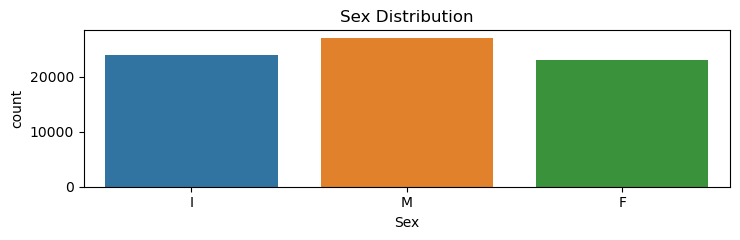

In [7]:
### discrete data analysis
plt.figure(figsize=(7.5,2.5))
sns.countplot(x=df_train.Sex, data=df_train)
plt.title("Sex Distribution")

plt.tight_layout()

In [8]:
def plot_data(data, data_type, plot_type):
    plt.figure(figsize=(15,10))
    if data_type == 'train':
        columns = data.columns[2:-1]
    else:
        columns = data.columns[2:]
        
    for id,column in enumerate(columns):  # we leave id and age features. because id is not important and the age is a categorical feature
        plt.subplot(4,2,id+1)
        if plot_type == 'hist':
            sns.histplot(x=column,data=df_train, kde=True)
            plt.title(f"{column} Distribution")
        elif plot_type == 'kde':
            sns.kdeplot(x=column,data=df_train, fill=True)
            plt.title(f"{column} Distribution")
        elif plot_type == 'box':
            sns.boxplot(x=column,data=df_train)
            plt.title(f"{column} Distribution")
        elif plot_type == 'scatter':
            sns.scatterplot(x=column,data=df_train, y='Age')
            plt.title(f"{column} Distribution")

        plt.tight_layout()
        
#     plt.figure(figsize=(7.5,2.5))
#     sns.countplot(x=data.Sex, data=data)
#     plt.title("Sex Distribution")

#     plt.tight_layout()

        

### EDA on Train data

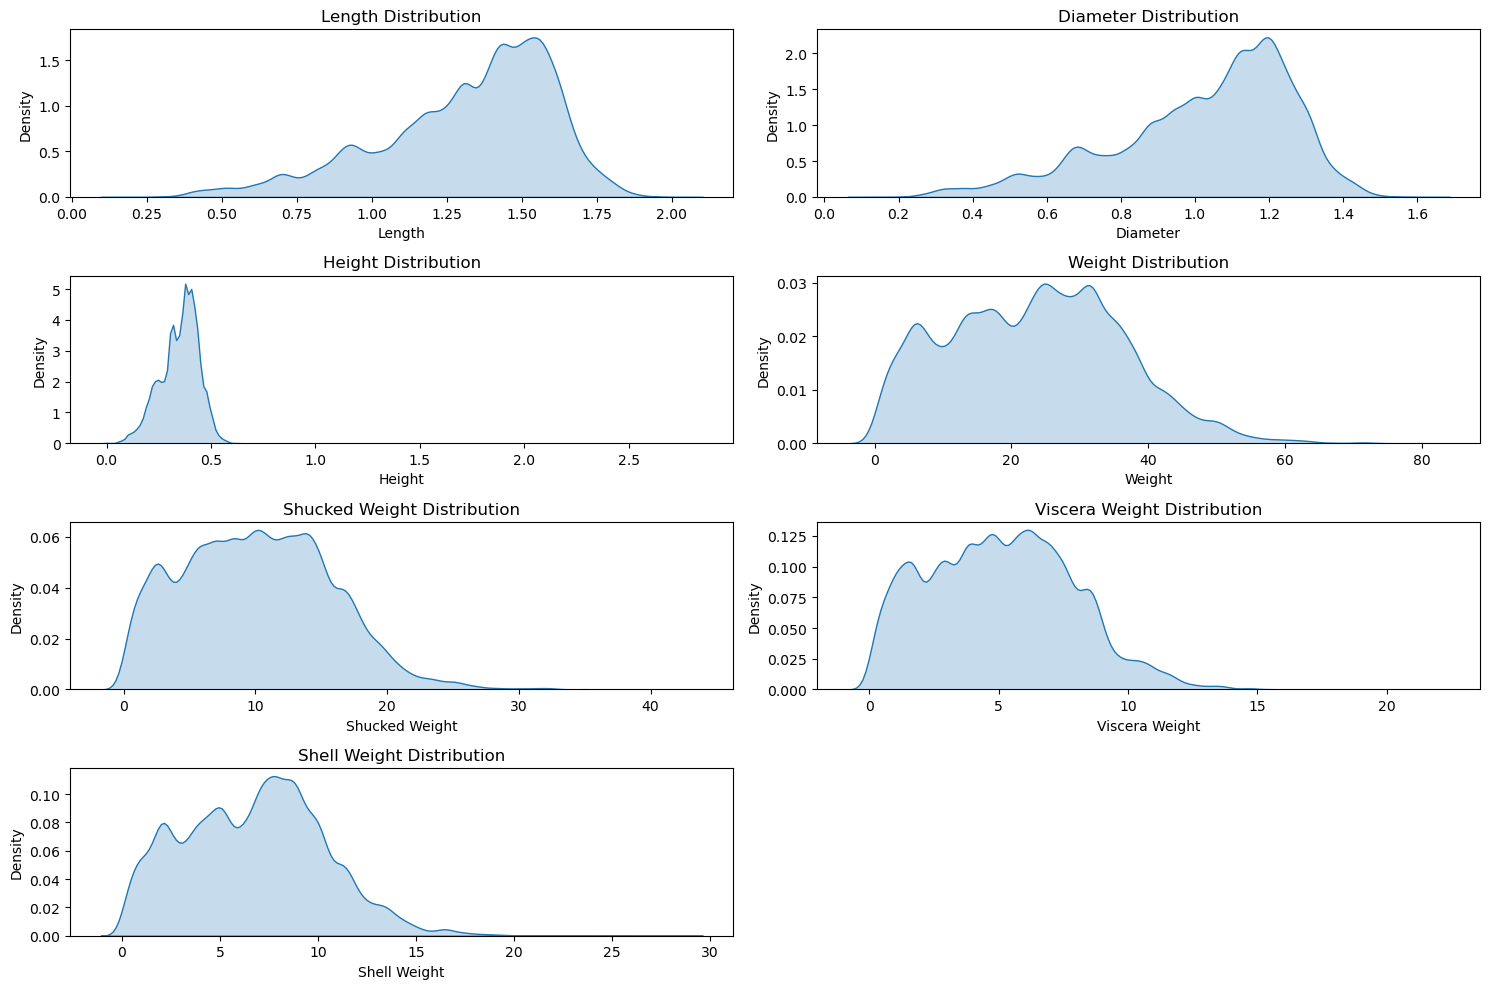

In [9]:
plot_data(df_train, 'train', 'kde')

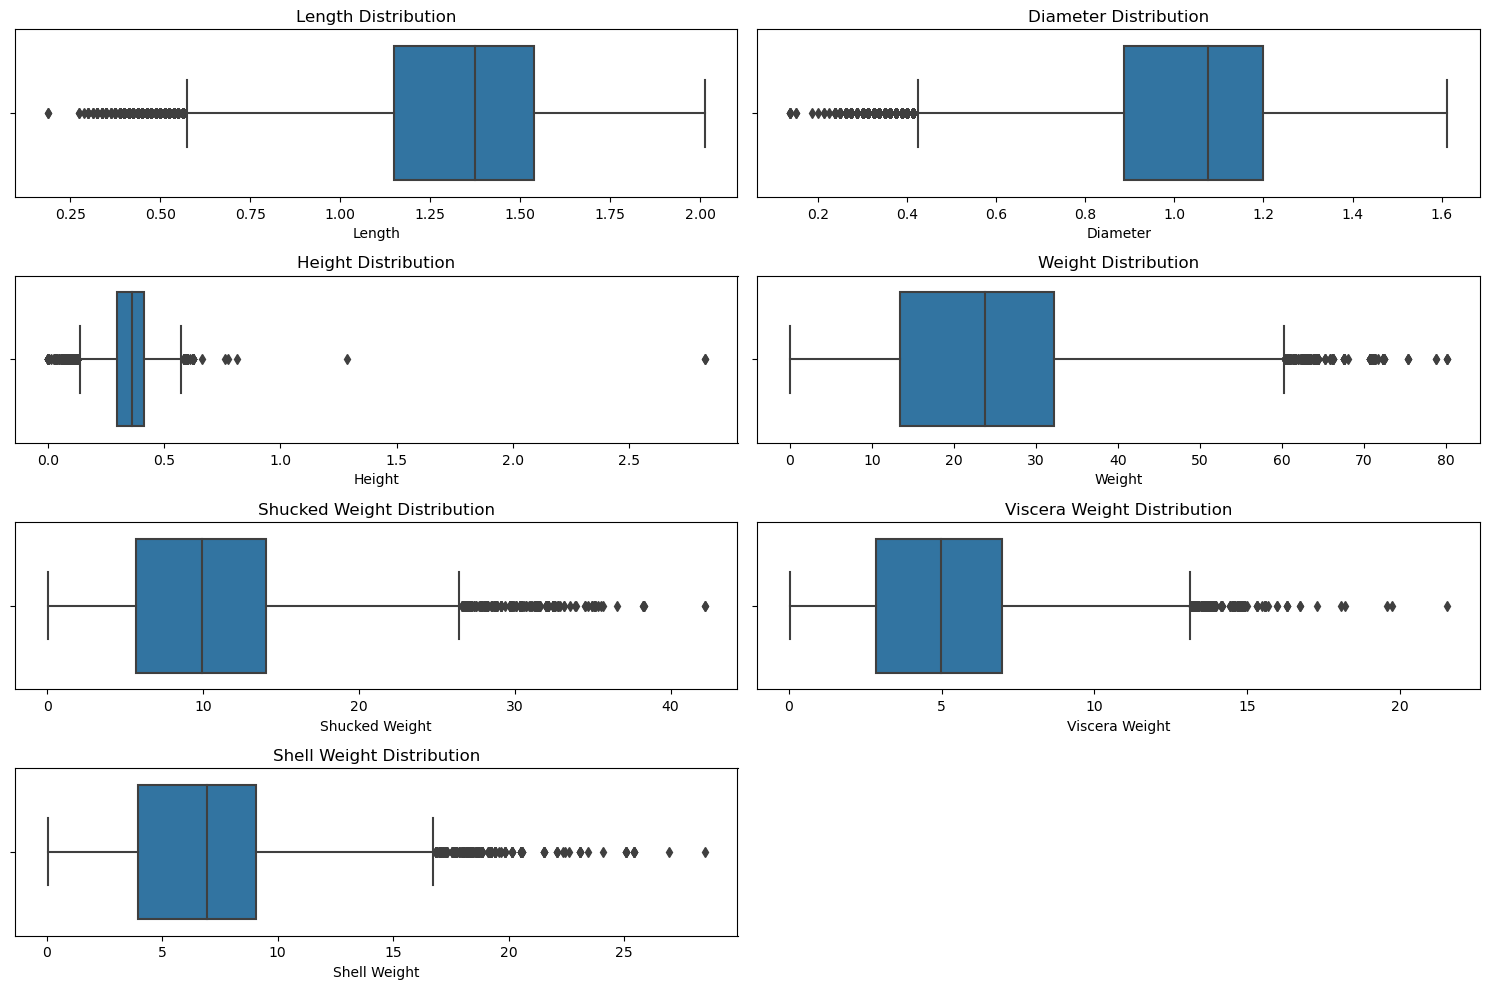

In [10]:
plot_data(df_train, 'train', 'box')

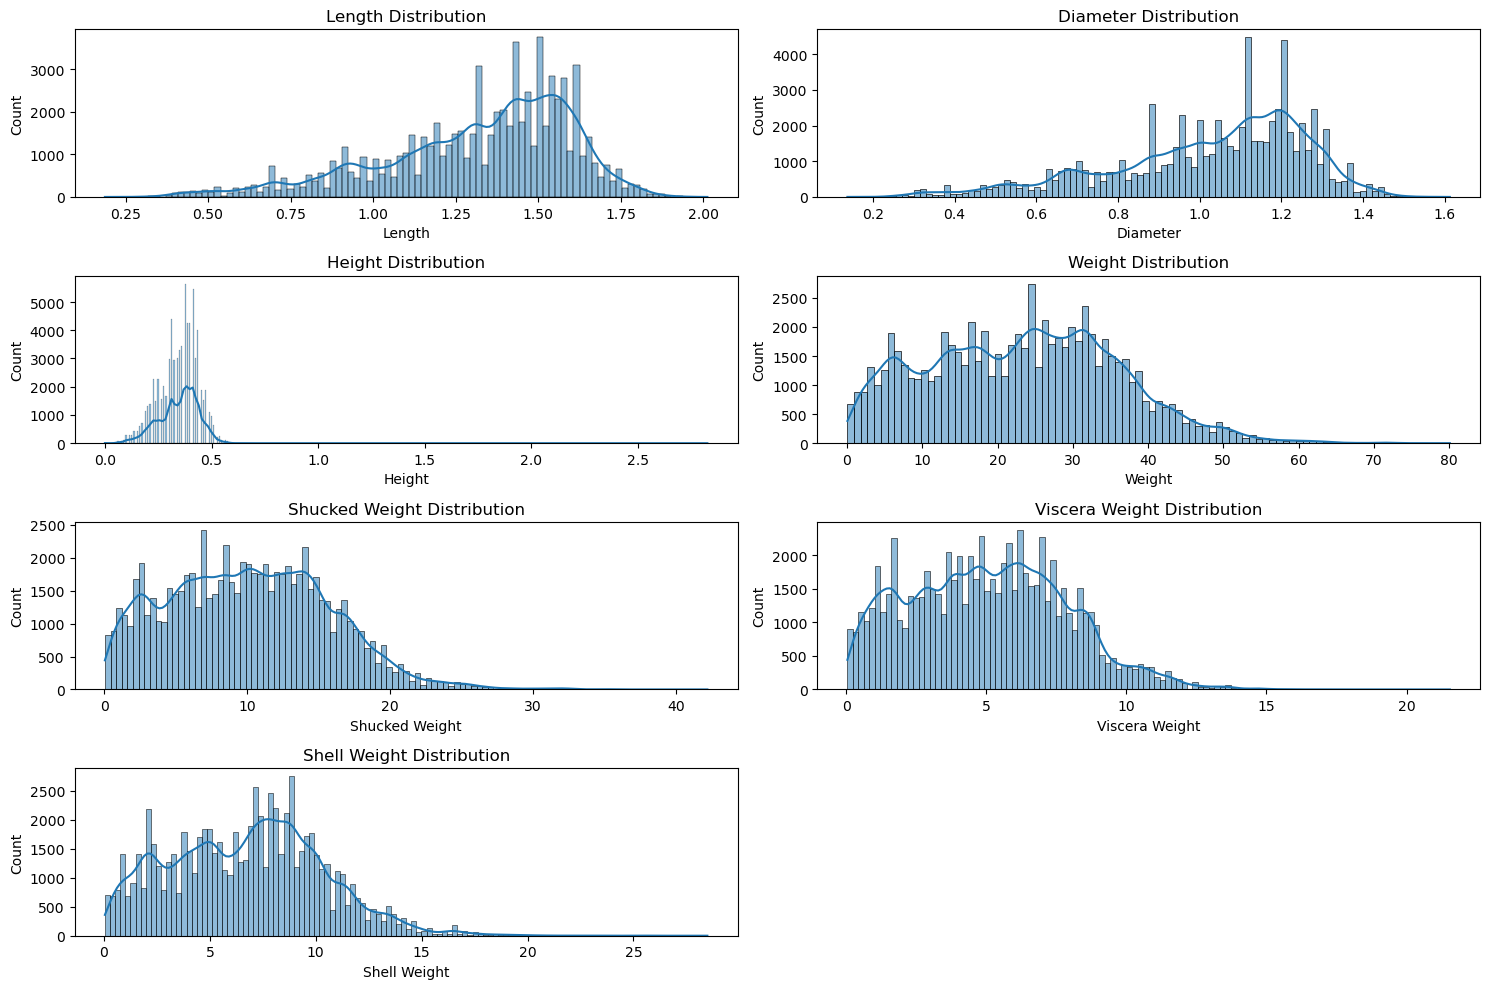

In [11]:
plot_data(df_train, 'train', 'hist')

### EDA on Test data

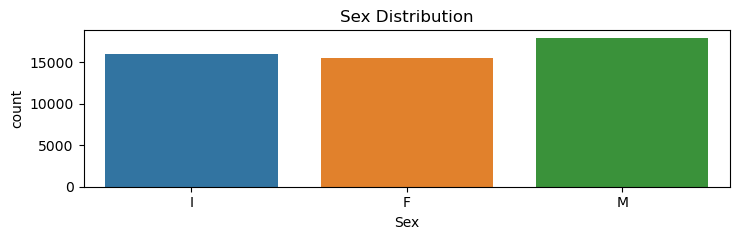

In [12]:
plt.figure(figsize=(7.5,2.5))
sns.countplot(x=df_test.Sex, data=df_test)
plt.title("Sex Distribution")

plt.tight_layout()

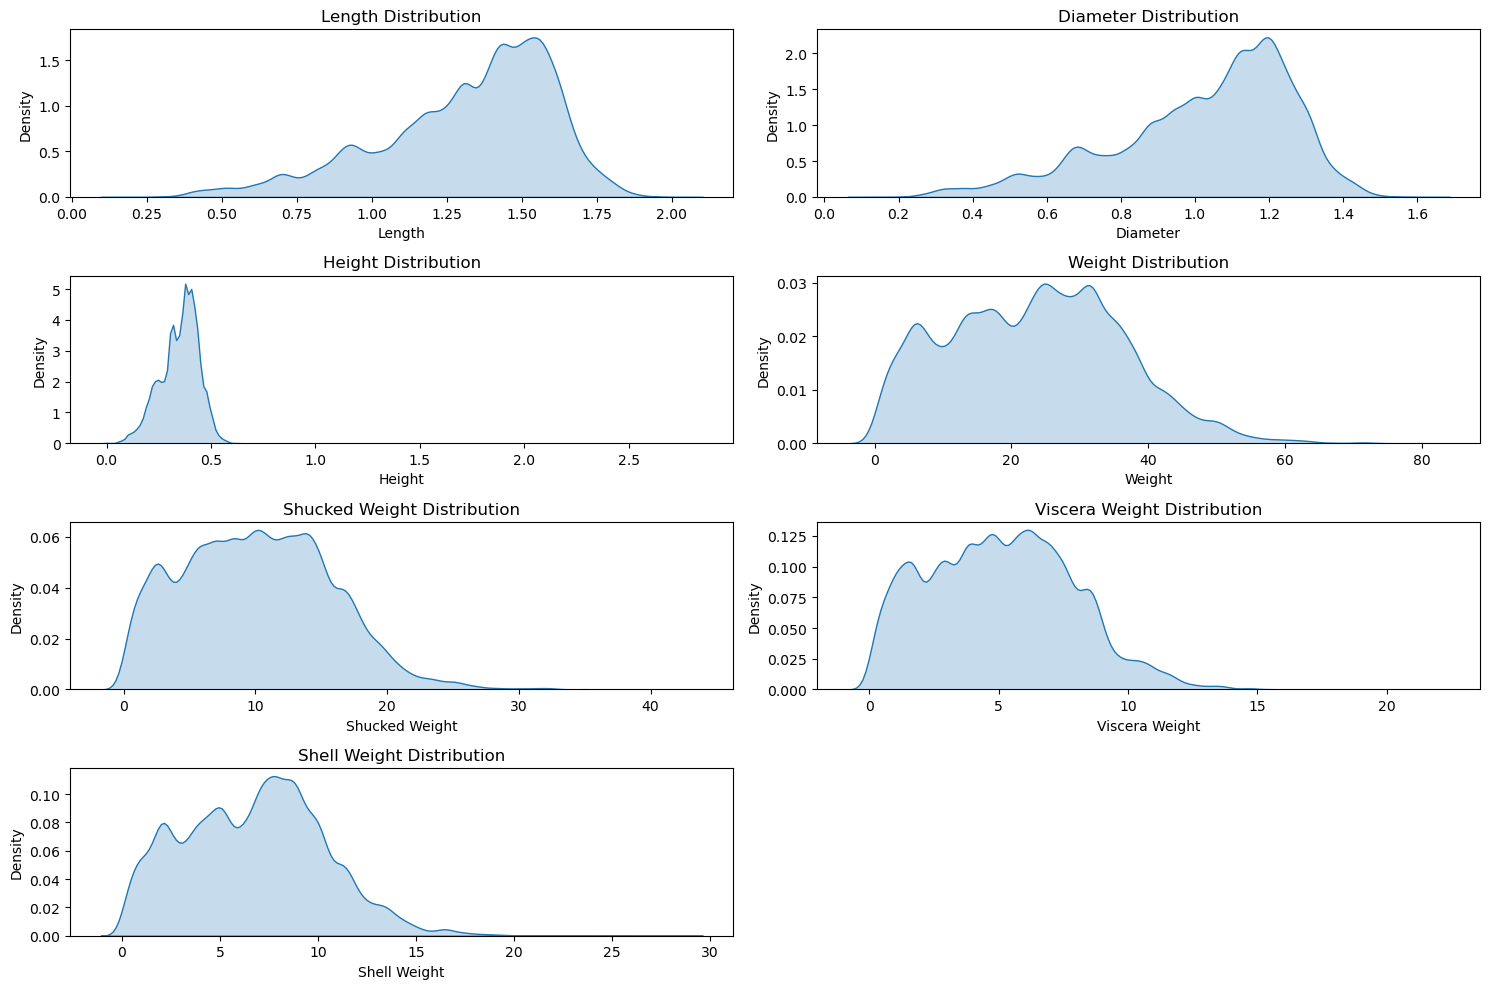

In [13]:
plot_data(df_test, 'test', 'kde')

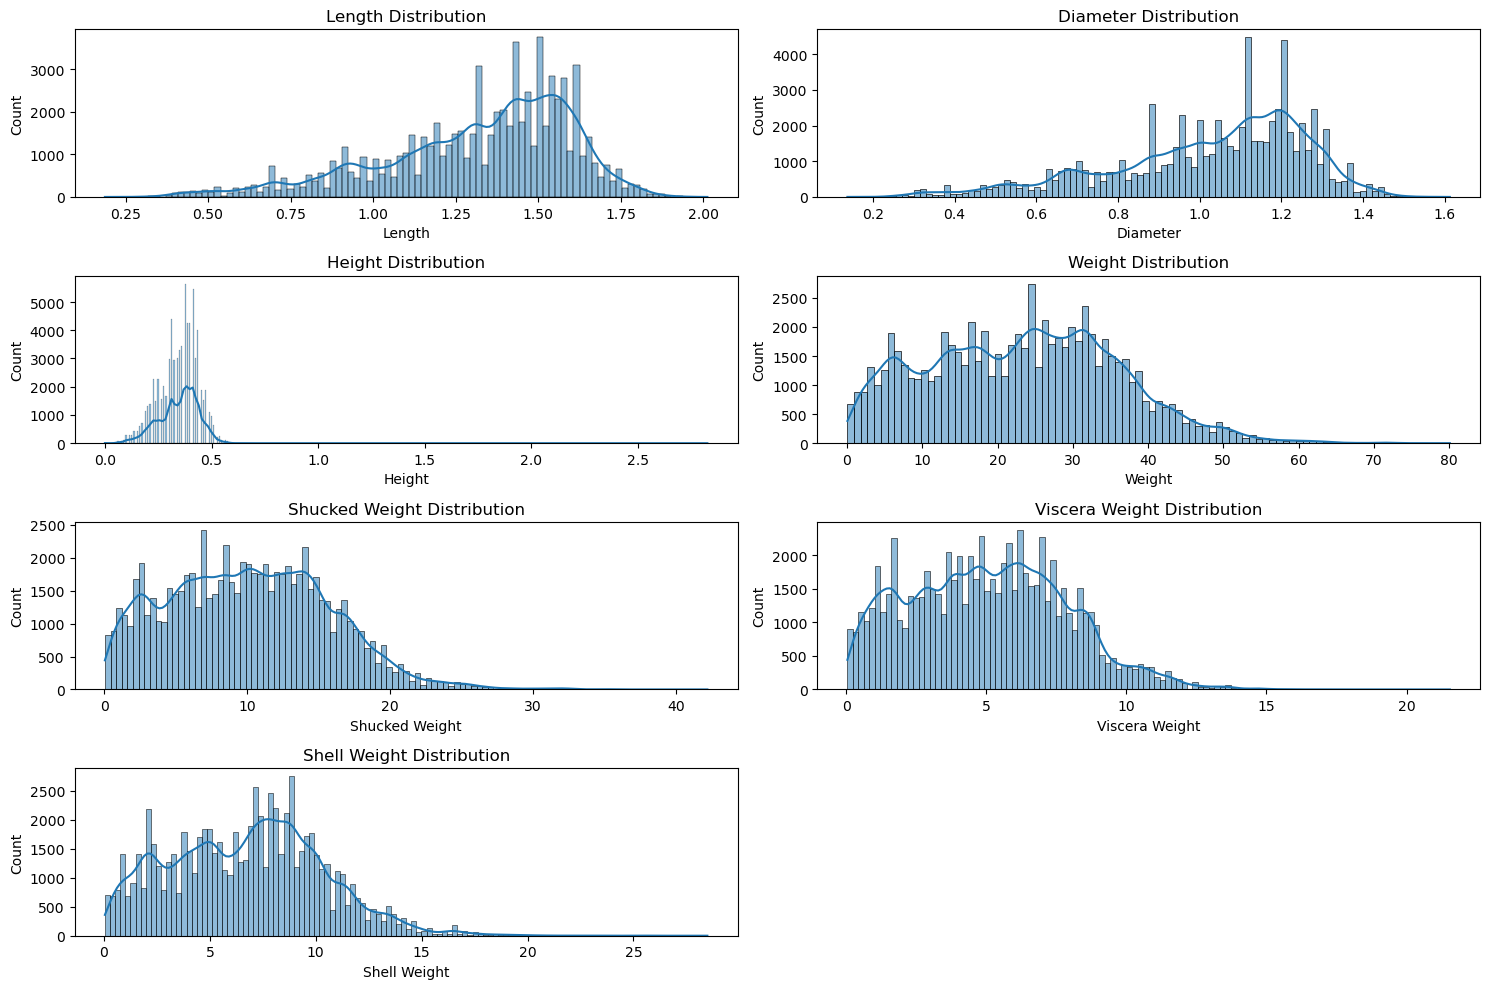

In [14]:
plot_data(df_test, 'test', 'hist')

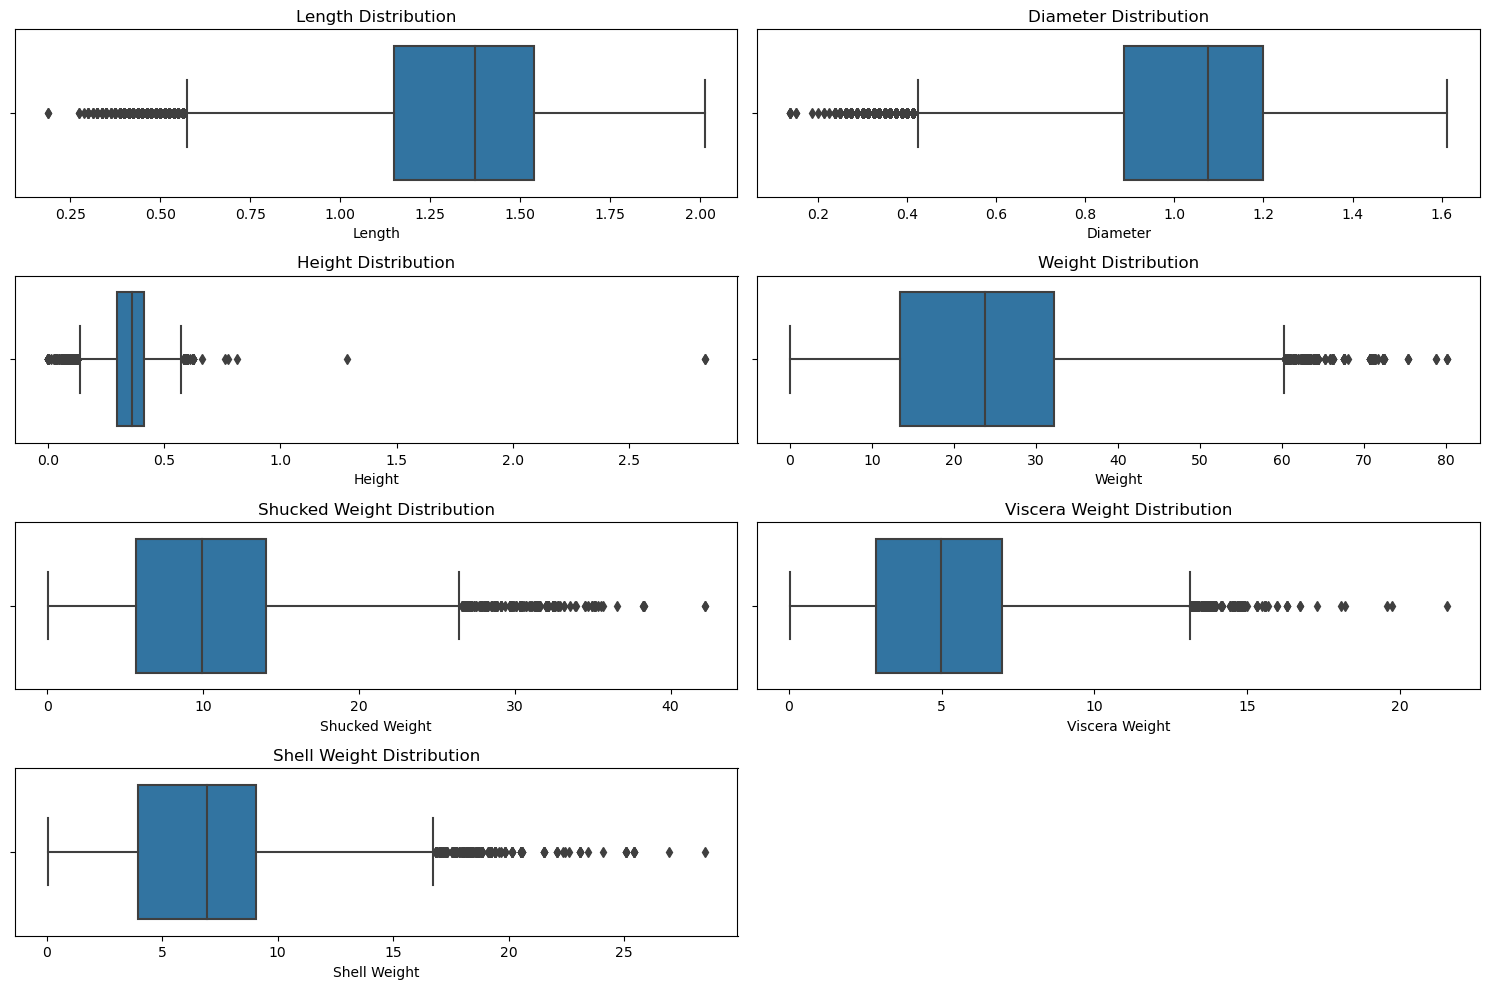

In [15]:
plot_data(df_test, 'test', 'box')

### Correlation Analysis

/tmp/ipykernel_24/1105751541.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat_train = df_train.iloc[:, 1:].corr()
/tmp/ipykernel_24/1105751541.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat_test = df_test.iloc[:, 1:].corr()


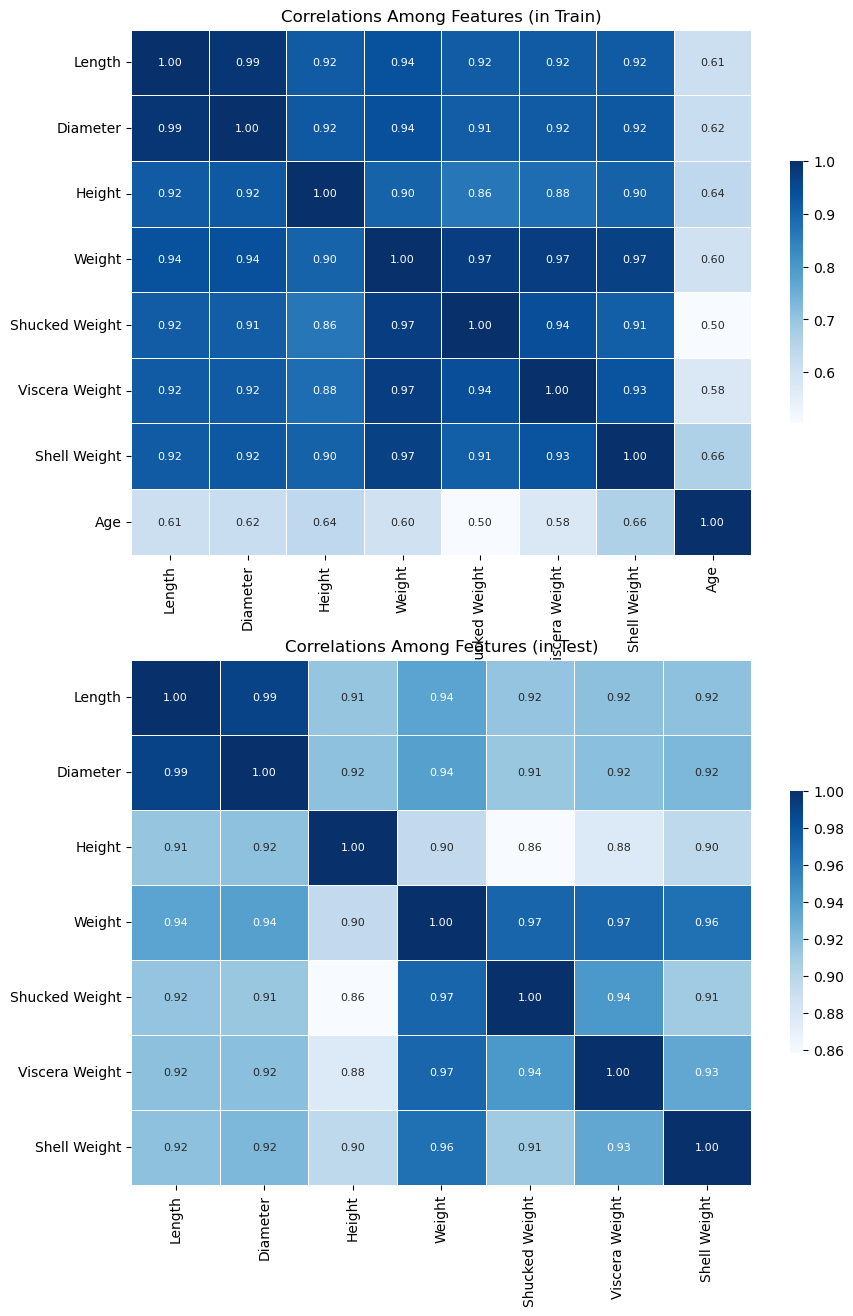

In [16]:
corr_mat_train = df_train.iloc[:, 1:].corr()
corr_mat_test = df_test.iloc[:, 1:].corr()

fig, axes = plt.subplots(2, 1, figsize = (10, 15))
sns.heatmap(corr_mat_train, annot = True, cmap = 'Blues', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features (in Train)')
sns.heatmap(corr_mat_test, annot = True, cmap = 'Blues', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features (in Test)');

##### It seems that the correlation between features are very high.

## Feature Engineering

### Feature Encoding using one hot encoding

In [17]:
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

In [18]:
df_train = pd.get_dummies(df_train)     

In [19]:
df_test = pd.get_dummies(df_test)

### Treat the outliers

In [20]:
def outliers(df, col, factor):

    Q1 = df[col].quantile(0.25)
    print(f"Q1 is :{Q1}")
    Q3 = df[col].quantile(0.75)
    print(f"Q3 is : {Q3}")



    IQR = Q3 - Q1
    print(f"IQR is :{IQR}")

    lower_bound = Q1 - (factor*IQR)
    print(f"lower bound is :{lower_bound}")
    upper_bound = Q3 + (factor*IQR)
    print(f"upper_bound is : {upper_bound}")

    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])  
        #       
    return df[col]

In [21]:
for col in df_train.columns[:-4]:
    df_train[col] = outliers(df_train, col, 1.5)

Q1 is :1.15
Q3 is : 1.5375
IQR is :0.3875000000000002
lower bound is :0.5687499999999996
upper_bound is : 2.1187500000000004
Q1 is :0.8875
Q3 is : 1.2
IQR is :0.3125
lower bound is :0.41874999999999996
upper_bound is : 1.66875
Q1 is :0.3
Q3 is : 0.4125
IQR is :0.11249999999999999
lower bound is :0.13125
upper_bound is : 0.5812499999999999
Q1 is :13.437663
Q3 is : 32.16250775
IQR is :18.724844750000003
lower bound is :-14.649604125000003
upper_bound is : 60.24977487500001
Q1 is :5.71242425
Q3 is : 14.0330025
IQR is :8.32057825
lower bound is :-6.768443125000001
upper_bound is : 26.513869875
Q1 is :2.8632995
Q3 is : 6.98815175
IQR is :4.12485225
lower bound is :-3.323978875
upper_bound is : 13.175430125
Q1 is :3.96893
Q3 is : 9.07184
IQR is :5.10291
lower bound is :-3.6854349999999996
upper_bound is : 16.726205


In [22]:
df_train.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0,1,0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0,1,0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0,0,1
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1,0,0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0,1,0


## Base model creation

##### Lets experiment several ml algorithms first.

In [23]:
X = df_train.drop('Age', axis=1)
y = df_train['Age']

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)

### Random Forest

In [25]:
rf_params = {
    'max_depth': 12,
    'min_samples_leaf': 10,
    'min_samples_split': 10
}

In [26]:
rf = RandomForestRegressor(random_state=100)
rf.fit(x_train, y_train)
prediction = rf.predict(df_test)
print(mean_absolute_error(y_test, rf.predict(x_test)))

1.4670723952060336


### Decision tree regressor

In [27]:
dt = DecisionTreeRegressor(random_state=100)
dt.fit(x_train, y_train)
print(mean_absolute_error(y_test, dt.predict(x_test)))

2.0253726235653677


### Gradient boosting regressor

In [28]:
gb_params = {
  'loss' : 'absolute_error',
  'n_estimators' : 1000, 
  'max_depth' : 8, 
  'learning_rate' : 0.01,
  'min_samples_split' : 10, 
  'min_samples_leaf' : 20
}

In [29]:
gb = GradientBoostingRegressor(**gb_params,random_state=100)
gb.fit(x_train, y_train)
print(mean_absolute_error(y_test, gb.predict(x_test)))

1.3560004066021598


### Hist Gradient Boosting Regressor

In [30]:
hist_params = {
    'loss' : 'absolute_error',
    'l2_regularization' : 0.01,
    'early_stopping' : False,
    'learning_rate' : 0.01,
    'max_iter' : 1000,
    'max_depth' : 15,
    'max_bins' : 255,
    'min_samples_leaf' : 30,
    'max_leaf_nodes' : 30
}

In [31]:
hgb = HistGradientBoostingRegressor(**hist_params, random_state=100)
hgb.fit(x_train, y_train)
print(mean_absolute_error(y_test, hgb.predict(x_test)))

1.3656171911797998


### XGB regressor

In [32]:
xgb_params = {
  'objective' : 'reg:pseudohubererror',
  'tree_method' : 'gpu_hist',
  'colsample_bytree' : 0.7, 
  'gamma' : 0.8, 
  'learning_rate' : 0.01, 
  'max_depth' : 8, 
  'min_child_weight' : 20, 
  'n_estimators' : 1000, 
  'subsample' : 0.7
}

In [33]:
xgboost = xgb.XGBRegressor(**xgb_params,random_state=100)
xgboost.fit(x_train, y_train)
print(mean_absolute_error(y_test, xgboost.predict(x_test)))

1.3627248528967841


### Catboost Regressor

In [34]:
cat = CatBoostRegressor(random_state=100, verbose=False)
cat.fit(x_train, y_train)
print(mean_absolute_error(y_test, cat.predict(x_test)))

1.4011149216713559


### LGBM Regressor

In [35]:
lgb_params  ={
   'objective' : 'mae', 
   'n_estimators' : 1000,
   'max_depth' : 10,
   'learning_rate' : 0.01,
   'num_leaves' :70,
   'reg_alpha' : 3, 
   'reg_lambda' : 3,
   'subsample' : 0.7,
   'colsample_bytree' : 0.7,
    'device' : 'gpu'
}

In [36]:
lgb = LGBMRegressor(**lgb_params,random_state=100)
lgb.fit(x_train, y_train)
print(mean_absolute_error(y_test, lgb.predict(x_test)))

1.3554445618598765


### Voting regressor

In [37]:
vr = VotingRegressor([('hgb', hgb), ('xgb', xgboost), ('gb', gb), ('lgb', lgb)])
vr.fit(x_train, y_train)
print(mean_absolute_error(y_test, vr.predict(x_test)))

1.354180217447133


In [38]:
prediction_vr = vr.predict(df_test)

In [39]:
prediction_vr

array([ 7.20559446,  7.92573666, 10.00214756, ..., 13.20616247,
        9.48434198, 11.40160688])

In [40]:
# dm_test = xgb.DMatrix(df_test)
# kfold = KFold(n_splits=20, shuffle=True, random_state=0)
# pred_xgb = np.zeros(df_test.shape[0])
# # pred_cat = np.zeros(df_test.shape[0])

# mae=[]  


# rmsle = []# list contains rmse for each fold
# n=0

# for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
#     x_train, y_train = X.iloc[train_index], y.iloc[train_index]
#     x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]

#     dm_cv_train = xgb.DMatrix(x_train, np.log1p(y_train))
#     dm_cv_test = xgb.DMatrix(x_valid, np.log1p(y_valid))

#     # XGBoost regressor

#     model_xgb = xgb.train(xgb_param, dm_cv_train)
#     pred_xgb+=model_xgb.predict(dm_test)/kfold.n_splits
#     val_pred = model_xgb.predict(dm_cv_test)
#     rmsle_xgb.append(mean_absolute_error(y_valid, val_pred))


#     print(f"fold: {n+1} mae xgb: {mae[n]}")
#     n+=1
# print(f"final mae  of {type} is :{np.mean(mae)}")   

In [41]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e16/sample_submission.csv')
submission['Age'] = prediction_vr

In [42]:
submission

,id,Age
0,74051,7.205594
1,74052,7.925737
2,74053,10.002148
3,74054,9.559704
4,74055,7.373438
...,...,...
49363,123414,8.490296
49364,123415,7.974521
49365,123416,13.206162
49366,123417,9.484342


In [43]:
submission.to_csv('submission.csv', index=False)